## Disclaimer

“The data reported here have been supplied by the United Network for Organ Sharing as the contractor for the Organ Procurement and Transplantation Network. The interpretation and reporting of these data are the responsibility of the author(s) and in no way should be seen as an official policy of or interpretation by the OPTN or the U.S. Government.”

This research was performed based on OPTN data as of July 15, 2021.

## Preprocessing and Training Data Development

For this part of the project, I need to do three steps.

1. Create dummy or indicator features for categorical variables
2. Standardize the magnitude of numeric features using a scaler
3. Split your data into testing and training datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('kidney.csv', index_col='Unnamed: 0')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400542 entries, 0 to 400541
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GFR                172834 non-null  float64
 1   ANTIBODY_TESTED    350916 non-null  object 
 2   GENDER             400542 non-null  int64  
 3   ABO                400542 non-null  object 
 4   PERM_STATE         399721 non-null  object 
 5   DGN_TCR            400542 non-null  int64  
 6   DIAB               400542 non-null  int64  
 7   INIT_WGT_KG        400542 non-null  float64
 8   INIT_HGT_CM        400542 non-null  float64
 9   INIT_EPTS          267785 non-null  float64
 10  END_EPTS           340828 non-null  float64
 11  INIT_AGE           400542 non-null  int64  
 12  INIT_DATE          400542 non-null  object 
 13  ETHCAT             400542 non-null  int64  
 14  INIT_BMI_CALC      400542 non-null  float64
 15  PERM_STATE_TRR     163687 non-null  object 
 16  TX

In [8]:
df.head().T

,0,1,2,3,4
GFR,19,NaN,NaN,NaN,NaN
ANTIBODY_TESTED,YA,YN,NaN,NaN,YA
GENDER,0,0,1,1,1
ABO,O,A,O,B,A
PERM_STATE,CA,CA,FL,SC,SC
DGN_TCR,3037,3011,3069,3070,3069
DIAB,5,5,2,2,2
INIT_WGT_KG,68.039,70.307,67.5,58,53
INIT_HGT_CM,175.26,182.88,162.56,153,155
INIT_EPTS,46,69,NaN,NaN,NaN


For reference, I'm explaining the features and some notes on them.
1. __GFR__: Kidney filteration rate. Not very complete data.
2. __Antibody_tested__: YN, YA, and NN and no info. perhaps I'll change NaN as 'other' and make category.
3. __Gender__: 0 is male and 1 is female.
4. __ABO__: bloodtype of patients. Make category.
5. __PERM_STATE__: WL patient state of residency. Redundant with PERM_STATE TRR.
6. __DGN_TCR__: Primary diagnosis (number coded). redundant with DIAG_KI. drop this. 
7. __DIAB__: Diabetes information (number coded). make category.
8. __INIT_WGT_KG__: Initial weight.
9. __INIT_HGT_CM__: Initial height.
10. __INIT_EPTS__: Initial calculated survival rate. 1/4 missing because it was recorded from 2014.
11. __END_EPTS__: End calculated survival rate. Less missing than INIT. perhaps just use this information and fill the missing values with median.
12. __INIT_AGE__: Initial Age. - Highly correlated with EPTS.
13. __INIT_DATE__: Date of admission. Use DAYSWAIT as replacement.
14. __ETHCAT__: Ethnicity (number coded). make category.
15. __INIT_BMI_CALC__: Calculated BMI. 
16. __PERM_STATE_TRR__: patient state of residency at treatment. make category. I will also make a ratio column which calculates the rate of WL patient getting transplanted in a state.
17. __TX_DATE__: Treatment date. Use DAYSWAIT as replacement. 
18. __NPKID__: Number of kidney transplants.
19. __AGE_DON__: Donor age, probably drop this because we won't know this info when a patient is waitlisted.
20. __ETHCAT_DON__: Donor ethnicity. Also drop.
21. __ABO_DON__: Donor bloodtype. Also drop.
22. __GENDER_DON__: Donor gender. Also drop. 
23. __HOME_STATE_DON__: Donor state. Also drop.
24. __ABO_MAT__: Bloodtype match. Also drop.
25. __AGE__: Recipient age. Also drop. (will be using INIT_AGE)
26. __DISTANCE__: Donor hospital to treatment center distance. nautical miles.
27. __DIAG_KI__: Kidney recipient primary diagnosis. make category.
28. __DIAG_OSTXT_KI__: text info about DIAG_KI. drop this.
29. __DAYSWAIT_CHRON_KI__: total days in kidney waitlist. - This will be my prediction variable (y variable!!)
30. __ORGAN__: filter for kidney(KI) only. Then drop. 
31. __BMI_CALC__: Recipient BMI. drop this info. will use INIT_BMI.
32. __TRR_ID_CODE__: df_t = df_wl[df_wl['TRR_ID_CODE'].notnull()] to get transplant data. Then drop.
33. __CTR_CODE__: Transplant center code. drop this. (use DISTANCE and PERM_STATE_TRR)
34. __LISTING_CTR_CODE__: WL center code. drop this. (use DISTANCE and PERM_STATE_TRR)
35. __year__: year entered WL center. drop this.

The goal of the analysis is to predict the waittime for a patient which is a regression problem. Also, since the patient will not have information about the donor at the time of listing. I will only keep the variables that are clear at the time of listing. I may have to return to select other features, but I will proceed with this set of features for now.

### 1. Dropping Columns and Rows.

In [11]:
df.drop(columns=['PERM_STATE','DGN_TCR','INIT_EPTS','INIT_DATE','TX_DATE','AGE_DON','ETHCAT_DON','ABO_DON','GENDER_DON',
                'HOME_STATE_DON','ABO_MAT','AGE','DIAG_OSTXT_KI','BMI_CALC','CTR_CODE','LISTING_CTR_CODE','year'], 
        inplace=True)

In [13]:
df = df[df['TRR_ID_CODE'].notnull()]

In [14]:
df.drop('TRR_ID_CODE', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
df.ORGAN.value_counts()

KI    166404
KP        17
Name: ORGAN, dtype: int64

In [18]:
df = df[df['ORGAN']=='KI']

In [20]:
df.drop('ORGAN', axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166404 entries, 5 to 400280
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GFR                74803 non-null   float64
 1   ANTIBODY_TESTED    138389 non-null  object 
 2   GENDER             166404 non-null  int64  
 3   ABO                166404 non-null  object 
 4   DIAB               166404 non-null  int64  
 5   INIT_WGT_KG        166404 non-null  float64
 6   INIT_HGT_CM        166404 non-null  float64
 7   END_EPTS           130709 non-null  float64
 8   INIT_AGE           166404 non-null  int64  
 9   ETHCAT             166404 non-null  int64  
 10  INIT_BMI_CALC      166404 non-null  float64
 11  PERM_STATE_TRR     163671 non-null  object 
 12  NPKID              166404 non-null  float64
 13  DISTANCE           166404 non-null  float64
 14  DIAG_KI            165520 non-null  float64
 15  DAYSWAIT_CHRON_KI  166404 non-null  float64
dtypes:

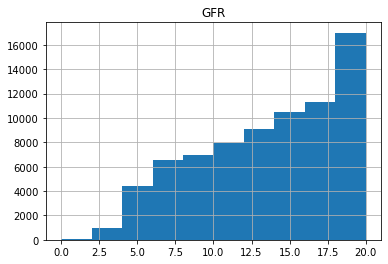

In [22]:
df.hist('GFR') 
plt.show()
# Unfortunately, there aren't many GFR information recorded. I will drop this variable too in the hope that 
# the DIAG_KI already take GFR information into account.

In [23]:
df.drop('GFR', axis=1, inplace=True)

In [25]:
df['ANTIBODY_TESTED'].fillna(value='unknown', inplace=True)

In [27]:
epts_med = df['END_EPTS'].median()

In [29]:
df['END_EPTS'].fillna(value=epts_med, inplace=True)

In [30]:
df['PERM_STATE_TRR'].value_counts() # Note 'ZZ' is the unknown state code.

CA    18108
TX    14326
NY    11658
FL    10464
IL     7628
PA     6891
OH     6004
MI     5290
NJ     5066
NC     5034
VA     4986
GA     4711
MD     4386
AZ     4165
MO     3269
MA     3149
TN     3127
WA     3106
IN     2857
WI     2747
MN     2704
SC     2604
CO     2320
AL     2294
LA     2100
KY     1861
CT     1757
IA     1723
OK     1695
MS     1574
KS     1493
OR     1476
UT     1390
AR     1273
NV     1256
NE     1119
NM      936
WV      821
PR      784
ID      758
RI      518
ME      518
NH      512
DC      508
HI      477
DE      447
SD      425
ND      353
MT      338
AK      240
WY      208
VT      163
VI       23
ZZ       19
AS        6
GU        4
MP        2
Name: PERM_STATE_TRR, dtype: int64

In [32]:
df['PERM_STATE_TRR'].fillna(value='ZZ', inplace=True)

In [42]:
df.DIAG_KI.fillna(value=999, inplace=True)

In [44]:
df['DIAG_KI']=df['DIAG_KI'].astype('int')

In [50]:
df_wl = pd.read_csv('kidney.csv', usecols=['PERM_STATE','PERM_STATE_TRR', 'TRR_ID_CODE'])

In [52]:
df_t = df_wl[df_wl['TRR_ID_CODE'].notnull()]

In [53]:
a = df_wl.groupby(['PERM_STATE']).size()
b = df_t.groupby(['PERM_STATE_TRR']).size()

In [55]:
ratio = b/a
df = df.merge(ratio.rename('ratio'), how='left', left_on ='PERM_STATE_TRR',right_index=True )

In [61]:
df['DAYSWAIT_CHRON_KI']=df['DAYSWAIT_CHRON_KI'].astype('float')

In [62]:
df.info() # filled every value and reduced the rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166404 entries, 5 to 400280
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ANTIBODY_TESTED    166404 non-null  object 
 1   GENDER             166404 non-null  int64  
 2   ABO                166404 non-null  object 
 3   DIAB               166404 non-null  int64  
 4   INIT_WGT_KG        166404 non-null  float64
 5   INIT_HGT_CM        166404 non-null  float64
 6   END_EPTS           166404 non-null  float64
 7   INIT_AGE           166404 non-null  int64  
 8   ETHCAT             166404 non-null  int64  
 9   INIT_BMI_CALC      166404 non-null  float64
 10  PERM_STATE_TRR     166404 non-null  object 
 11  NPKID              166404 non-null  float64
 12  DISTANCE           166404 non-null  float64
 13  DIAG_KI            166404 non-null  int64  
 14  DAYSWAIT_CHRON_KI  166404 non-null  float64
 15  ratio              166404 non-null  float64
dtypes:

### 2. Scaling

Noncategorical values are __INIT_WGT_KG, INIT_HGT_CM, END_EPTS, INIT_AGE, INIT_BMI_CALC, DISTANCE, ratio__.
Also the DAYSWAIT_CHRON_KI is the prediction feature (y).

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['INIT_WGT_KG','INIT_HGT_CM','END_EPTS','INIT_AGE','INIT_BMI_CALC','DISTANCE','ratio']] = scaler.fit_transform(df[['INIT_WGT_KG','INIT_HGT_CM','END_EPTS','INIT_AGE','INIT_BMI_CALC','DISTANCE','ratio']])

In [67]:
df.head()

,ANTIBODY_TESTED,GENDER,ABO,DIAB,INIT_WGT_KG,INIT_HGT_CM,END_EPTS,INIT_AGE,ETHCAT,INIT_BMI_CALC,PERM_STATE_TRR,NPKID,DISTANCE,DIAG_KI,DAYSWAIT_CHRON_KI,ratio
5,unknown,0,O,2,0.781752,0.774301,-0.081352,-0.750183,2,0.380087,SC,0.0,-0.245505,3069,184.0,-0.452993
28,unknown,1,O,2,-1.037128,-0.551874,-0.081352,-1.130134,2,-0.933057,SC,0.0,0.893569,3070,8.0,-0.452993
29,unknown,1,O,2,-0.914477,-0.054559,-0.081352,-0.306908,1,-1.123117,TX,1.0,0.564042,3069,289.0,-0.769778
48,unknown,1,A,2,-0.750985,0.111213,-0.081352,-0.876833,1,-1.019448,OK,1.0,-0.442703,3069,478.0,1.300809
57,unknown,0,AB,3,2.028354,0.774301,-0.081352,0.326343,1,1.848735,WI,0.0,-0.455676,3070,3.0,0.282546


### 3. Dummy variable

For the rest of categorical variables, I will be making Dummy variable (one hot!)

In [69]:
df=pd.get_dummies(df, columns=['ANTIBODY_TESTED','ABO','DIAB','ETHCAT','PERM_STATE_TRR','NPKID','DIAG_KI'], drop_first=True)

In [70]:
df.shape # the columns increased to 160.

(166404, 160)

In [71]:
df.to_csv('KI_features.csv')

### 4. Split into Train and Test set

I will just write the code to split the train and test set here. But I will be performing it again right before the actual modeling.

In [73]:
X=df.drop('DAYSWAIT_CHRON_KI', axis=1)

In [75]:
y=df[['DAYSWAIT_CHRON_KI']]

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=1)

In [79]:
y_train.shape, y_test.shape

((124803, 1), (41601, 1))

In [80]:
X_train.shape, X_test.shape

((124803, 159), (41601, 159))